# AlexNet

## 核方法 2001 SVM
- 特征提取
- 选择核函数来计算相关性
- 凸优化问题
- 漂亮的定理

## 几何学 2000 计算机视觉
- 抽取特征
- 描述几何(例如多相机)
- （非）凸优化
- 漂亮定理
- 如果假设满足了，效果

## 特征工程
- 特征工程是关键
- 特征描述子：SIFT，SURF
- 视觉词袋（聚类）
- 最后用了SIFT

## 硬件
通过GPU的大规模应用，计算能力涨幅(10000X)已经超过数据量的涨幅(1000X)

## ImageNet(2010)
|图片|自然物体的彩色图片(ImageNet)|手写数字的黑白图片(MNIST)|
|----|----|----|
|大小|$469\times 387$|28\times 28|
|样本数|1.2M|60K|
|类数|1000|10|

## AlexNet
- 赢得2012年ImageNet竞赛
- 更深更大的LeNet
- 主要改进：
  - 丢弃法
  - ReLU
  - MaxPooling
- 计算机视觉方法论的改变：
  - Image->人工特征提取->SVM
  - Image->通过CNN学习特征->Softmax回归

## AlexNet架构
[参数个数][计算数FLOP]->总计[46M][1G]
```
image(3x224x224) ->
11x11 conv(96),stride 4 [35K][101M]->  # 更大的核窗口核步长，因为图片更大了
3x3 MaxPool,stride 2 ->  # 更大的池化窗口，使用最大池化层
5x5 conv(256),pad 2 [614K][415M]-> # 更大的输出通道
3x3 MaxPool,stride 2 ->
3x3 conv(384),pad 1 [3M][445M]->
3x3 conv(384),pad 1 [3M][445M]->
3x3 conv(384),pad 1 [3M][445M]->
3x3 MaxPool,stride 2 ->
Dense(4096) [26M][26M]->
Dense(4096) [16M][16M]->
Dense(1000) 
```
- trick
  - 激活函数从Sigmoid变到了ReLU（减缓梯度消失）
  - 隐藏全连接层后加入了丢弃层
  - 数据增强

## 总结
- AlexNet是更大更深的LeNet，10x参数个数，260x计算复杂度
- 新进入了丢弃法，ReLU，最大池化层和数据增强
- 在赢得2012ImageNet竞赛后，标志着新的一轮神经网络热潮的开始

# 代码实现（AlexNet）

In [ ]:
# !pip install d2l

In [10]:
# !pip install matplotlib_inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


报错：ImportError: cannot import name '_check_savefig_extra_args' from 'matplotlib.backend_bases'，更新下matplotlib版本，d2l的安装导致matplotlib的降级

In [28]:
# !pip install matplotlib==3.0.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.3/36.3 MB 30.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for matplotlib: filename=matplotlib-3.0.0-cp38-cp38-linux_x86_64.whl size=11844596 sha256=69416d4ca32b3ebf16276374dcaeb5aaba604e40ccad768054db117e9e781cc4
  Stored in directory: /root/.cache/pip/wheels/a9/1e/ed/3e09c67472517aa5d81f8c15de6c81162d249ebe442e4f3007
Successfully built matplotlib
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.1
    Uninstalling matplotlib-3.5.1:
      Successfully uninstalled matplotlib-3.5.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.5 requires matplotlib!=3.0.0,>=2.0.2, but you have matplotlib 3.0.0 which is incompatible.
scikit-image 0.18.3 req

In [30]:
import torch
from torch import nn
from d2l import torch as d2l
# import d2l_source.d2l as d2l
net = nn.Sequential(
    # 这里使用一个11*11的更大窗口来捕捉对象。
    # 同时，步幅为4，以减少输出的高度和宽度。
    # 另外，输出通道的数目远大于LeNet
    nn.Conv2d(1, 96, kernel_size=11, stride=4, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    # 减小卷积窗口，使用填充为2来使得输入与输出的高和宽一致，且增大输出通道数
    nn.Conv2d(96, 256, kernel_size=5, padding=2), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    # 使用三个连续的卷积层和较小的卷积窗口。
    # 除了最后的卷积层，输出通道的数量进一步增加。
    # 在前两个卷积层之后，汇聚层不用于减少输入的高度和宽度
    nn.Conv2d(256, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 256, kernel_size=3, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Flatten(),
    # 这里，全连接层的输出数量是LeNet中的好几倍。使用dropout层来减轻过拟合
    nn.Linear(6400, 4096), nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(4096, 4096), nn.ReLU(),
    nn.Dropout(p=0.5),
    # 最后是输出层。由于这里使用Fashion-MNIST，所以用类别数为10，而非论文中的1000
    nn.Linear(4096, 10))

构造一个1x1x224x224数据来观察每一层输出的形状

In [31]:
X = torch.randn(1, 1, 224, 224)
for layer in net:
    X=layer(X)
    print(layer.__class__.__name__,'output shape:\t',X.shape)

Conv2d output shape:	 torch.Size([1, 96, 54, 54])
ReLU output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([1, 96, 26, 26])
Conv2d output shape:	 torch.Size([1, 256, 26, 26])
ReLU output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape:	 torch.Size([1, 256, 12, 12])
Conv2d output shape:	 torch.Size([1, 384, 12, 12])
ReLU output shape:	 torch.Size([1, 384, 12, 12])
Conv2d output shape:	 torch.Size([1, 384, 12, 12])
ReLU output shape:	 torch.Size([1, 384, 12, 12])
Conv2d output shape:	 torch.Size([1, 256, 12, 12])
ReLU output shape:	 torch.Size([1, 256, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 256, 5, 5])
Flatten output shape:	 torch.Size([1, 6400])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1,

读取数据集

In [32]:
batch_size = 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


训练

loss 0.335, train acc 0.878, test acc 0.865
1426.5 examples/sec on cuda:0


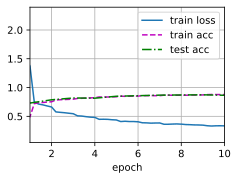

In [33]:
lr, num_epochs = 0.01, 10
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [34]:
!nvidia-smi

Mon Feb  6 18:12:23 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   74C    P0    33W /  70W |   3412MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------